#### Name: Eric Lindgren
#### CID: ericlin
#### PSN: 970222-1954

## Bayesian Optimization

In [29]:
# Imports
# KEYS
#
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import GPy

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

### Task 1

In [22]:
def true_func(x):
    '''The true function for which we wish to find the min.'''
    return np.sin(6*x) + 0.2*x**2 - 0.7*x


# Tests
print(f'True function passing unit test: {-1.137==np.round(true_func(2),3)}')

True function passing unit test: True


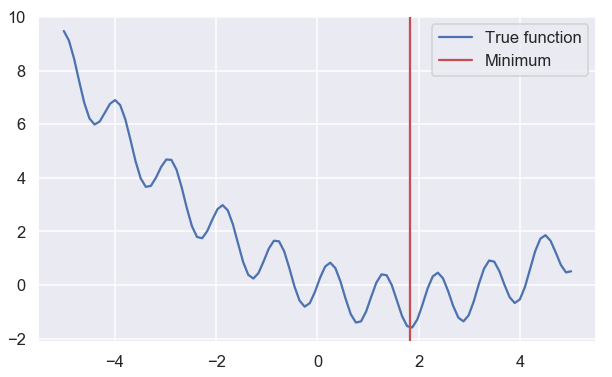

In [24]:
#Plot
x = np.linspace(-5,5,100)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, true_func(x), label='True function')
# The minimum is at around 2
ax.axvline(1.825, color='r', label='Minimum')
plt.legend(loc="best")

In [46]:
# Minimize using scipy.optimize for 100 times

np.random.seed(1)  # Set seed 
nbr_iter = 100  # Number of optimizations
nbr_correct = 0  # Number of ''correct'' optimizations
function_calls_correct = []  # An array containing the number of function calls for each succesful termination
x_star = 1.825  # The estimated minimum from the plot above
tol = 0.05  # The range in which we want our solution to get for a successful minimum

# Rename sp.optimize.minimize as minmz
minmz = sp.optimize.minimize

for i in range(nbr_iter):
    # Draw a random starting point in the interval x \in (-5, 5).
    x_start= np.random.uniform(-5,5)
    # Optimize using Nealder Mead, with a
    opt_results = minmz(fun=true_func, x0=x_start, method='Nelder-Mead', tol=0.01)
    # Check if terminated to x_star
    x_star_opt = opt_results.x
    if np.abs(x_star - x_star_opt) < tol:
        #print(f'Optimization terminated succesfully to {x_star_opt}')
        nbr_correct += 1  # Increase number of correct optimizations
        function_calls_correct.append(opt_results.nit)  # Append number of function calls
        
# Sanity check
assert nbr_correct == len(function_calls_correct)

# Print results
print(f'Number of succesful terminations: {nbr_correct} out of {nbr_iter}.')
print(f'Average number of optimization iterations per succesful termination: {np.mean(function_calls_correct):.2f}.')

Number of succesful terminations: 12 out of 100.
Average number of optimization iterations per succesful termination: 6.08.


### Task 2

In [ ]:
def LCB_fun(model, D_k):
    '''Implements the Lower Confidence Bound (LCB) acquisition function for GP model 'model'.'''
    mean = 
    sigma = 
    return mean-sigma
    

In [93]:
np.random.seed(1)  # Set seed 
k = 2  # The number of starting points
nbr_iter = 100  # The number of sampling points
X = np.random.uniform(-5,5, k)  # Sample k random starting points in the interval
Y = true_func(X)
# Reshape for GPy, it's picky
X = X.reshape(k,1)
Y = Y.reshape(k,1)

# Initialize the data vector 
D = np.array([X,Y])  # TODO check so correctly formatted



# Define the statistical model, which is a Gaussian defined by a covariance matrix from a GPy covariance function
kernel = GPy.kern.RBF(input_dim=1)  # Use a defualt RBF covariance function, since we have no prior information
model = GPy.models.GPRegression(D[0],D[1],kernel)
model['rbf.lengthscale'].constrain_bounded(.1,10)  # Constrain the lengthscale of the model so it doesn't get too small
model.optimize()  # Optimize the model to the current data

for i in range(k,nbr_iter):
    # Select x_i by optimizeing the acquisition function
    x_i = np.array(1).reshape(1,1)  # TODO
    # Evaluate the objective function for x_i
    y_i = np.array(true_func(x_i)).reshape(1,1)
    # Combine and reshape for data vector
    xy = np.array([x_i, y_i])
    # Append this to the data vector
    D = np.append(D, xy)
    # Re-optimize the statistical model for the data
    model = GPy.models.GPRegression(D[0],D[1],kernel)
    pass


reconstraining parameters GP_regression.rbf.lengthscale


(1, 1)
(1, 1)


AssertionError: 